In [1]:
#!pip install transformers
#!pip install albumentations

In [2]:
import torch
from tqdm.auto import tqdm
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
import os
import matplotlib.pyplot as plt

def binary_to_logit_mask(masks):
    C, H, W = masks.shape
    # Create an array of shape (C, H, W) where each channel is its index
    channel_indices = np.arange(C)[:, None, None] + 1
    # Replace False with a sentinel value (e.g., C) to ignore in min()
    masked_indices = np.where(masks, channel_indices, C + 1)
    # Find the minimum index (first True) along axis=0
    logits = np.min(masked_indices, axis=0)
    # Set positions where no mask was True to -1
    logits[logits == C + 1] = 0
    return logits

def unnormalize_image(image,processor):
    from PIL import Image

    if "torch" in str(type(image)):
        image = image.numpy()

    mean = processor.image_mean
    std = processor.image_std

    unnormalized_image = (image * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
    unnormalized_image *= 255 
    unnormalized_image[unnormalized_image > 255] = 255 
    unnormalized_image[unnormalized_image < 0] = 0
    unnormalized_image = (unnormalized_image).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

def plot_data(img,anns_semantic,anns_instances=None, n_classes=50, background_class:int=0):
    if "torch" in str(type(anns_semantic)):
        anns_semantic = anns_semantic.numpy()

    if "torch" in str(type(anns_instances)):
        anns_instances = anns_instances.numpy()

    # 0 is background
    plt.imshow(img)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    if (len(anns_semantic.shape) == 1) and (anns_instances is not None):
        if len(anns_instances.shape) == 3: 
            anns_instances = binary_to_logit_mask(anns_instances)

        anns_semantic = np.stack(
            [
                (anns_instances == 0) * background_class, 
                *[(anns_instances == i+1) * anns_semantic[i] for i in range(len(anns_semantic))]
            ],
            axis=0
        )
        
        anns_semantic = np.sum(anns_semantic,axis=0)
        if background_class != 0:
            anns_semantic += 1
            anns_semantic[anns_semantic == background_class + 1] = 0

        anns_instances *= (anns_semantic != 0)

    elif len(anns_semantic.shape) == 3: 
        anns_semantic = binary_to_logit_mask(anns_semantic)

    mask = np.zeros((anns_semantic.shape[0], anns_semantic.shape[1], 3), dtype=np.uint8)
    # Generate a list of n colors from the `gist_rainbow` colormap
    cmap = plt.colormaps['gist_rainbow']
    colors = (cmap(np.linspace(0, 1, n_classes))[:, :3]*255).astype(np.uint8)  # Convert to RGB

    for id in np.unique(anns_semantic):
        if id == 0:
            continue 

        color_mask = colors[id-1]
        mask[anns_semantic == id] = color_mask

    if anns_instances is not None:
        if len(anns_instances.shape) == 3: 
            anns_instances = binary_to_logit_mask(anns_instances)

        for id in np.unique(anns_instances):
            if id == 0:
                continue 

            import cv2
            contours, _ = cv2.findContours((anns_instances == id).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(mask, contours, -1, (255,255,255), thickness=1) 

    alpha_channel = np.ones((mask.shape[0],mask.shape[1],1),dtype=mask.dtype) * 127
    alpha_channel[(mask[:, :, 0] == 255) & (mask[:, :, 1] == 255) & (mask[:, :, 2] == 255)] = 255 
    alpha_channel[(mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0)] = 0 
    mask = np.concatenate((mask, alpha_channel),axis=2)
    mask[:,:,:3][mask[:,:,3] == 255] = 0
 
    ax.imshow(mask)

    return None


class CocoMask2FormerDataset(Dataset):
    def __init__(self, annotation_file, processor, n_classes, root=None, transform=None):
        if root is None:
            root = os.path.dirname(annotation_file)

        self.img_folder = os.path.normpath(root)
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        self.processor = processor
        
        self.transform = transform
        self.n_classes = n_classes

    def __len__(self):
        return len(self.image_ids)

    def image_id(self,idx):
        return self.image_ids[idx]
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.img_folder, img_info['file_name'])
        image = np.array(Image.open(img_path).convert("RGB"))

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        height, width = img_info['height'], img_info['width']
        
        masks = []
        class_ids = [0]

        for ann in anns:
            rle = ann['segmentation']
            if isinstance(rle, list):
                rle = mask_utils.frPyObjects(rle, height, width)
                rle = mask_utils.merge(rle)

            mask = mask_utils.decode(rle)
            # Ensure we get only binary mask (some RLEs are multi-channel)
            if mask.ndim == 3:
                mask = mask[:, :, 0]

            masks.append(mask)#*ann['id'])
            class_ids.append(ann['category_id'])

        # If no annotations, return dummy
        if len(masks) == 0:
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, image.shape[0], image.shape[1]), dtype=torch.uint8)
            return inputs

        # Stack masks into a single array: (num_instances, H, W)
        masks = np.stack(masks,axis=0)
        #masks = np.sum(masks,axis=0)
        masks = binary_to_logit_mask(masks)

        # Optional: apply transforms (e.g. Albumentations or torchvision)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=masks)
            image, masks = transformed['image'], transformed['mask']
            image = image.transpose(2, 0, 1)  # C, H, W
            image[image > 255] = 255
            image[image < 0] = 0
        else:
            None
            image = image.transpose(2, 0, 1)

        # Create instance_id to semantic_id mapping
        inst2class = {i: class_ids[i] for i in range(len(class_ids))}

        # Process inputs
        inputs = self.processor([image], [masks], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        inputs = {k: v.squeeze(0) if isinstance(v, torch.Tensor) else v[0] for k, v in inputs.items()}
        return inputs

In [3]:
def load_model(task='semantic'):
    from transformers import Mask2FormerForUniversalSegmentation, AutoImageProcessor
    if task == 'instance':
        image_processor = AutoImageProcessor.from_pretrained(
            'facebook/mask2former-swin-large-coco-instance'
        )
        model = Mask2FormerForUniversalSegmentation.from_pretrained(
            'facebook/mask2former-swin-large-coco-instance'
        )
    
    if task == 'semantic':
        image_processor = AutoImageProcessor.from_pretrained(
            'facebook/mask2former-swin-large-ade-semantic'
        )
        model = Mask2FormerForUniversalSegmentation.from_pretrained(
            'facebook/mask2former-swin-large-ade-semantic'
        )
    if task == 'panoptic':
        image_processor = AutoImageProcessor.from_pretrained(
            'facebook/mask2former-swin-large-coco-panoptic'
        )
        model = Mask2FormerForUniversalSegmentation.from_pretrained(
            'facebook/mask2former-swin-large-coco-panoptic'
        )
    return model, image_processor

In [4]:
def train_test_split(dataset, test_size: float = 0.2, shuffle: bool = False, random_state: int = 42):
    from torch.utils.data import Subset
    from sklearn.model_selection import train_test_split as sklearn_train_test_split
    import copy
    # Step 1: Extract image IDs
    image_ids = [dataset.image_id(i) for i in range(len(dataset))]

    # Step 2: Find unique IDs and split
    unique_ids = list(set(image_ids))
    train_ids, test_ids = sklearn_train_test_split(
        unique_ids, test_size=test_size, random_state=random_state, shuffle=shuffle
    )

    # Step 3: Index the dataset by matching image IDs
    train_indices = [i for i in range(len(dataset)) if dataset.image_id(i) in train_ids]
    test_indices  = [i for i in range(len(dataset)) if dataset.image_id(i) in test_ids]

    # end alternate constructor
    # Step 4: Create train and test subsets
    train_dataset = Subset(dataset, train_indices)

    # Step 5: Clone dataset for test set and set its transform to None
    test_dataset_base = copy.deepcopy(dataset)
    test_dataset_base.transform = None
    test_dataset = Subset(test_dataset_base, test_indices,)


    return train_dataset, test_dataset

In [5]:
def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  return mask

In [6]:
np.random.seed(42)

In [7]:
annotation_file_train = "/home/miguel/Documents/Proyectos/SismicaUPM/instance_segmentation/dataset/train_annotations_coco.json"
annotation_file_test = "/home/miguel/Documents/Proyectos/SismicaUPM/instance_segmentation/dataset/test_annotations_coco.json"

In [8]:
model, processor = load_model(task='instance')
processor.do_reduce_labels = True
processor.ignore_index = 255

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/miguel/python_envs/geoSAM2/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [10]:
import albumentations as A

transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.RandomCrop(height=256, width=256, p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

/home/miguel/python_envs/geoSAM2/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
train_dataset = CocoMask2FormerDataset(annotation_file=annotation_file_train,processor=processor,n_classes=1,transform=transform)
test_dataset = CocoMask2FormerDataset(annotation_file=annotation_file_train,processor=processor,n_classes=1,transform=None)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [12]:
inputs = train_dataset[0]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([3, 384, 384])
pixel_mask torch.Size([384, 384])
mask_labels torch.Size([4, 384, 384])
class_labels torch.Size([4])


In [13]:
np.unique(inputs["pixel_mask"])

array([1])

In [14]:
from torch.utils.data import DataLoader 

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False, collate_fn=collate_fn)

In [15]:
test_batch = next(iter(test_dataloader))
for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([6, 3, 384, 384])
pixel_mask torch.Size([6, 384, 384])
class_labels 6
mask_labels 6


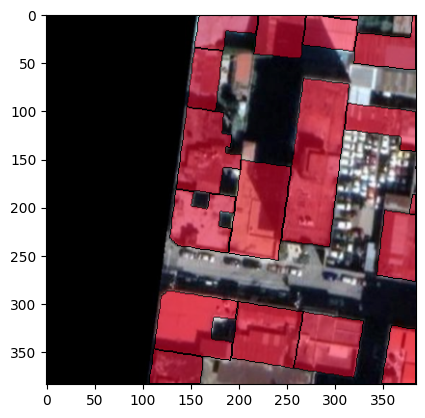

In [16]:
batch_index = 0
img = test_batch["pixel_values"][batch_index] 
img = unnormalize_image(img,processor=processor)
anns_semantic = test_batch["class_labels"][batch_index]
anns_instances = test_batch["mask_labels"][batch_index]
plot_data(img,anns_semantic=anns_semantic,anns_instances=anns_instances,background_class=255)

In [17]:
with torch.no_grad(): 
        outputs = model(
                pixel_values=test_batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in test_batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in test_batch["class_labels"]],
        )
        print(outputs.loss)
        results = processor.post_process_instance_segmentation(outputs)[0]#, target_sizes=[img.size[::-1]])[0]
        outputs = None
        print(f"Found {len(results['segmentation'])} instances")

tensor(177.3907, device='cuda:0')
Found 384 instances


In [18]:
from evaluation import Evaluator
e = Evaluator(
    dimension=2,
    allow_overlap=True, # Allow overlapping instance masks in binary inputs
    match_method='hungarian', 
    image_average=False # False computes average over all instances True computes average metric over all images
)

In [19]:
def evaluate(model,test_dataloader,evaluator,device='cpu'):
    import copy
    evaluator = copy.deepcopy(evaluator)
    test_batch = next(iter(test_dataloader))
    loss = 0 
    n_samples = 0
    for test_batch in test_dataloader:
        with torch.no_grad():
            outputs = model(
                    pixel_values=test_batch["pixel_values"].to(device),
                    mask_labels=[labels.to(device) for labels in test_batch["mask_labels"]],
                    class_labels=[labels.to(device) for labels in test_batch["class_labels"]],
            )
        results = processor.post_process_instance_segmentation(outputs)#, target_sizes=[img.size[::-1]])[0]
        loss += outputs.loss
        n_samples += len(outputs)
        outputs = None
        for i in range(len(results)):
            res = results[i]
            anns_instances = [get_mask(res['segmentation'], segment['id']) for segment in res['segments_info']]
            anns_instances = np.stack(anns_instances,axis=0)
            anns_semantic = np.array([segment['label_id'] for segment in res['segments_info']])
            anns_semantic_gt = test_batch["class_labels"][i].numpy()
            anns_instances_gt = test_batch["mask_labels"][i].numpy()
            evaluator.add_example(anns_instances, anns_instances_gt,verbose=False) 

    aji = evaluator.AJI()
    sbd = evaluator.SBD()
    pq = evaluator.PQ()
    mAP = evaluator.mAP()
    sAP = evaluator.sortedAP()
    print("Loss: ", loss / n_samples)

    return {'AJI':aji,'SBD':sbd,'PQ':pq,'mAP':mAP,'sAP':sAP,'loss':loss/n_samples}

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


losses = []
test_values = []
for epoch in range(30):
  print("Epoch:", epoch)
  model.train()
  running_loss = 0.0
  num_samples = 0
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
              pixel_values=batch["pixel_values"].to(device),
              mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
              class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 10 == 0:
        print("Train loss:", running_loss/num_samples)
        torch.save(model.state_dict(), f"mask2former_model_epoch_{epoch}.pth")


      # Optimization
      optimizer.step()

  losses.append(running_loss/num_samples)
  test_values.append(evaluate(model,test_dataloader=test_dataloader,evaluator=e,device=device))
  print("Test loss: ", test_values[-1]['loss'])



test_values = {key: [d[key] for d in test_values] for key in test_values[0]}
test_values['test_loss'] = test_values['loss']
test_values['train_loss'] = losses

Epoch: 0


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 57.74188232421875
Train loss: 27.457357493313875
Train loss: 22.373030798775808
Train loss: 19.46421241760254
Train loss: 18.499695754632718
Train loss: 17.54011935813754
Train loss: 16.80012915564365
Train loss: 16.453907335308237
Train loss: 16.11699107841209
Train loss: 15.582762026524806
Train loss: 15.203609268264016
Train loss: 14.906727039062226
Train loss: 14.729614592780752
Train loss: 14.506369448800124
Train loss: 14.264905388473618
Train loss: 14.07025840582437
Train loss: 13.838589573498838
Train loss: 13.743227423283091
Train loss: 13.567727218016735
aggregatedJaccard: 0.48174260543341846, image average: False
SBD: 0.4932003677623506, image average: False
PQ: 0.40879989667758354, image average: False
mAP: 0.20130665465619463, image average: False
sortedAP: 0.3168723249813709, image average: False
Loss:  tensor(4.0411, device='cuda:0')
Test loss:  tensor(4.0411, device='cuda:0')
Epoch: 1


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 15.209931373596191
Train loss: 12.19353251023726
Train loss: 11.459323474339076
Train loss: 11.750077032273815
Train loss: 11.556789270261438
Train loss: 11.500313562505385
Train loss: 11.528293523632112
Train loss: 11.41164920027827
Train loss: 11.497512081523
Train loss: 11.437278155442122
Train loss: 11.36427652245701
Train loss: 11.373120466868082
Train loss: 11.332648009308114
Train loss: 11.316864297590183
Train loss: 11.195859882003028
Train loss: 11.123863191794086
Train loss: 11.105004005550597
Train loss: 11.12100709390919
Train loss: 11.197226598117892
aggregatedJaccard: 0.46035217371880804, image average: False
SBD: 0.4111763387481498, image average: False
PQ: 0.34290668464360835, image average: False
mAP: 0.1580724270123514, image average: False
sortedAP: 0.2622479818634095, image average: False
Loss:  tensor(3.7670, device='cuda:0')
Test loss:  tensor(3.7670, device='cuda:0')
Epoch: 2


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 10.995481491088867
Train loss: 10.730495062741367
Train loss: 10.735692024230957
Train loss: 11.350553820210118
Train loss: 10.98800627778216
Train loss: 10.861977044273825
Train loss: 10.773130557576163
Train loss: 10.878353521857463
Train loss: 10.67660035027398
Train loss: 10.65957131752601
Train loss: 10.598195996614965
Train loss: 10.531624222660923
Train loss: 10.592746182906726
Train loss: 10.568288140624533
Train loss: 10.585549422189699
Train loss: 10.499700044164594
Train loss: 10.420453397383602
Train loss: 10.437213805683871
Train loss: 10.422844892048705
aggregatedJaccard: 0.547956443264852, image average: False
SBD: 0.5249826815842861, image average: False
PQ: 0.43757241453007134, image average: False
mAP: 0.2215985386224147, image average: False
sortedAP: 0.3466523467301002, image average: False
Loss:  tensor(3.6261, device='cuda:0')
Test loss:  tensor(3.6261, device='cuda:0')
Epoch: 3


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 15.164728164672852
Train loss: 11.400998549027877
Train loss: 10.372829210190545
Train loss: 10.156876256389003
Train loss: 9.736483143597114
Train loss: 9.869970461901497
Train loss: 9.691669745523422
Train loss: 9.729763151894153
Train loss: 9.672202286896882
Train loss: 9.677214821616372
Train loss: 9.73678740888539
Train loss: 9.628334234426687
Train loss: 9.712444348768754
Train loss: 9.719824568915913
Train loss: 9.718237707800899
Train loss: 9.693434399484799
Train loss: 9.600756366800818
Train loss: 9.565135057906659
Train loss: 9.600157558588691
aggregatedJaccard: 0.5581322417946736, image average: False
SBD: 0.4960231039085738, image average: False
PQ: 0.43538548724133236, image average: False
mAP: 0.22302726711536952, image average: False
sortedAP: 0.3381815151684322, image average: False
Loss:  tensor(3.1730, device='cuda:0')
Test loss:  tensor(3.1730, device='cuda:0')
Epoch: 4


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 8.745797157287598
Train loss: 9.87831618569114
Train loss: 10.279581637609573
Train loss: 9.884953345021893
Train loss: 9.807181742133164
Train loss: 9.485438038321103
Train loss: 9.460669642589131
Train loss: 9.395359287799245
Train loss: 9.37648206875648
Train loss: 9.344171812246135
Train loss: 9.41638163292762
Train loss: 9.351665574151117
Train loss: 9.26700999914122
Train loss: 9.265339720340176
Train loss: 9.222665485760844
Train loss: 9.270984207557527
Train loss: 9.26517829539613
Train loss: 9.30748380694473
Train loss: 9.292387564537934
aggregatedJaccard: 0.5820710644199472, image average: False
SBD: 0.5669018729150931, image average: False
PQ: 0.48336448559211964, image average: False
mAP: 0.2574219084710666, image average: False
sortedAP: 0.38214199264563364, image average: False
Loss:  tensor(3.3176, device='cuda:0')
Test loss:  tensor(3.3176, device='cuda:0')
Epoch: 5


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 13.964092254638672
Train loss: 10.635781548239969
Train loss: 9.578686339514595
Train loss: 9.731539780093778
Train loss: 9.679887940243978
Train loss: 9.563834774727916
Train loss: 9.382558662383282
Train loss: 9.164591372852595
Train loss: 9.181139751716897
Train loss: 9.300944726545731
Train loss: 9.295312919239006
Train loss: 9.313432964118752
Train loss: 9.277273966261179
Train loss: 9.263010225223221
Train loss: 9.174811525547758
Train loss: 9.145738977470145
Train loss: 9.198859857476275
Train loss: 9.264986595912287
Train loss: 9.264306808703513
aggregatedJaccard: 0.5199976228519491, image average: False
SBD: 0.6503229211680781, image average: False
PQ: 0.4946461793201684, image average: False
mAP: 0.269474068197305, image average: False
sortedAP: 0.40052965072401414, image average: False
Loss:  tensor(3.8385, device='cuda:0')
Test loss:  tensor(3.8385, device='cuda:0')
Epoch: 6


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 12.668168067932129
Train loss: 10.931607419794256
Train loss: 9.782056513286772
Train loss: 9.467331301781439
Train loss: 9.384971502350599
Train loss: 9.4383064438315
Train loss: 9.266946479922435
Train loss: 9.182372425643491
Train loss: 9.135229572837735
Train loss: 9.133336614776443
Train loss: 9.10913376524897
Train loss: 9.050213540996516
Train loss: 9.088156260734747
Train loss: 9.063445089427569
Train loss: 9.064984194775844
Train loss: 9.154222275247637
Train loss: 9.302972125710909
Train loss: 9.33624489683854
Train loss: 9.413788277799911
aggregatedJaccard: 0.5184834856185809, image average: False
SBD: 0.4678015158978314, image average: False
PQ: 0.4150973326360541, image average: False
mAP: 0.20874402699645356, image average: False
sortedAP: 0.3179917983736271, image average: False
Loss:  tensor(3.1050, device='cuda:0')
Test loss:  tensor(3.1050, device='cuda:0')
Epoch: 7


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 6.715878009796143
Train loss: 9.297682892192494
Train loss: 9.023154451733543
Train loss: 9.058466765188403
Train loss: 9.294615658318124
Train loss: 9.165945908602547
Train loss: 9.604811461245427
Train loss: 9.83633460125453
Train loss: 9.905586292714249
Train loss: 9.866440372152644
Train loss: 9.751776253823007
Train loss: 9.644768064086502
Train loss: 9.73329106441214
Train loss: 9.813517612355357
Train loss: 9.867995338237032
Train loss: 9.944450285261041
Train loss: 9.963215666528074
Train loss: 9.98280514471712
Train loss: 10.00503733803554
aggregatedJaccard: 0.5362366314772545, image average: False
SBD: 0.4762893812393774, image average: False
PQ: 0.4176031333421383, image average: False
mAP: 0.20932814654513834, image average: False
sortedAP: 0.3225434382368953, image average: False
Loss:  tensor(3.1860, device='cuda:0')
Test loss:  tensor(3.1860, device='cuda:0')
Epoch: 8


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 8.803739547729492
Train loss: 9.691637169231068
Train loss: 9.452701341538202
Train loss: 9.66366014172954
Train loss: 9.38015560987519
Train loss: 9.45758038408616
Train loss: 9.382061219606243
Train loss: 9.354766553556415
Train loss: 9.571603059768677
Train loss: 9.501598135455625
Train loss: 9.579773636147527
Train loss: 9.587383933969447
Train loss: 9.5778769993585
Train loss: 9.517438475412266
Train loss: 9.465915350203819
Train loss: 9.340694422753442
Train loss: 9.288775869037794
Train loss: 9.258653558485689
Train loss: 9.17886546303554
aggregatedJaccard: 0.591005915133848, image average: False
SBD: 0.5241899364606998, image average: False
PQ: 0.4598430911725316, image average: False
mAP: 0.2419244180490676, image average: False
sortedAP: 0.3603094820523438, image average: False
Loss:  tensor(2.9201, device='cuda:0')
Test loss:  tensor(2.9201, device='cuda:0')
Epoch: 9


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 10.185269355773926
Train loss: 9.306993224404074
Train loss: 8.608643963223411
Train loss: 8.700889987330283
Train loss: 8.668041194357523
Train loss: 8.724129854464064
Train loss: 8.750296803771473
Train loss: 8.735607462869563
Train loss: 8.672299061292483
Train loss: 8.69341175372784
Train loss: 8.684300738986176
Train loss: 8.64485247070725
Train loss: 8.689477321530177
Train loss: 8.781168162367726
Train loss: 8.95013910658816
Train loss: 9.03090097730523
Train loss: 9.064254932522033
Train loss: 9.069628180119029
Train loss: 9.092502030219821
aggregatedJaccard: 0.5723648247504235, image average: False
SBD: 0.5087317779528577, image average: False
PQ: 0.4552740740478896, image average: False
mAP: 0.2389318620815677, image average: False
sortedAP: 0.35444101575356035, image average: False
Loss:  tensor(2.9957, device='cuda:0')
Test loss:  tensor(2.9957, device='cuda:0')
Epoch: 10


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 12.256291389465332
Train loss: 10.34264664216475
Train loss: 9.448713223139444
Train loss: 9.312076299421248
Train loss: 9.120200872421265
Train loss: 9.077724629757451
Train loss: 9.00657106227562
Train loss: 9.032874110718849
Train loss: 8.883275482389662
Train loss: 8.724296865882454
Train loss: 8.743478149470716
Train loss: 8.804774930885246
Train loss: 8.810725683023122
Train loss: 8.7247140953559
Train loss: 8.725672226425603
Train loss: 8.71393041263353
Train loss: 8.699461023259607
Train loss: 8.648477887549596
Train loss: 8.68385353272791
aggregatedJaccard: 0.5867349003398173, image average: False
SBD: 0.513198210874675, image average: False
PQ: 0.4679740214532685, image average: False
mAP: 0.24924990278051476, image average: False
sortedAP: 0.363086932583461, image average: False
Loss:  tensor(2.8109, device='cuda:0')
Test loss:  tensor(2.8109, device='cuda:0')
Epoch: 11


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 10.931395530700684
Train loss: 8.76922980221835
Train loss: 8.878810155959357
Train loss: 9.195994238699637
Train loss: 8.92602102930953
Train loss: 8.839848873662014
Train loss: 8.699352358208328
Train loss: 8.531775937953466
Train loss: 8.636507128491814
Train loss: 8.67101057283171
Train loss: 8.71238596132486
Train loss: 8.740486490833867
Train loss: 8.703161363759317
Train loss: 8.741574387513955
Train loss: 8.766749691455923
Train loss: 8.777589436398436
Train loss: 8.817004317822663
Train loss: 8.790973134905274
Train loss: 8.755421900617483
aggregatedJaccard: 0.6055858334548047, image average: False
SBD: 0.5766880464192403, image average: False
PQ: 0.5045454394431205, image average: False
mAP: 0.27673675513992047, image average: False
sortedAP: 0.40068213947126424, image average: False
Loss:  tensor(2.8747, device='cuda:0')
Test loss:  tensor(2.8747, device='cuda:0')
Epoch: 12


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 12.23797607421875
Train loss: 8.876734690232711
Train loss: 8.374125457945324
Train loss: 8.09373995565599
Train loss: 7.968675124935988
Train loss: 8.35534226660635
Train loss: 8.232895679161198
Train loss: 8.281313318601796
Train loss: 8.221963358514103
Train loss: 8.204163399371472
Train loss: 8.08734947147936
Train loss: 8.176561097841006
Train loss: 8.195190721306918
Train loss: 8.240564633871763
Train loss: 8.332271792364459
Train loss: 8.28308025732735
Train loss: 8.289385945160197
Train loss: 8.306534135550784
Train loss: 8.324671683390497
aggregatedJaccard: 0.6202114053444076, image average: False
SBD: 0.5408260090329539, image average: False
PQ: 0.4868611913169825, image average: False
mAP: 0.2645229969653085, image average: False
sortedAP: 0.38073951067646544, image average: False
Loss:  tensor(2.6779, device='cuda:0')
Test loss:  tensor(2.6779, device='cuda:0')
Epoch: 13


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 8.302151679992676
Train loss: 8.822745539925315
Train loss: 8.797139031546456
Train loss: 9.032466211626607
Train loss: 8.830155523811898
Train loss: 8.639140820970722
Train loss: 8.401485779246347
Train loss: 8.315560515497772
Train loss: 8.334082980214813
Train loss: 8.269405868027237
Train loss: 8.30705451965332
Train loss: 8.326941906868875
Train loss: 8.380383625503415
Train loss: 8.409743607499218
Train loss: 8.417061244342344
Train loss: 8.313396535961834
Train loss: 8.35917047536151
Train loss: 8.338076446488587
Train loss: 8.312447210701789
aggregatedJaccard: 0.6154729399528951, image average: False
SBD: 0.4945190858982556, image average: False
PQ: 0.45670950775134406, image average: False
mAP: 0.24108731945216463, image average: False
sortedAP: 0.3491507968932381, image average: False
Loss:  tensor(2.7097, device='cuda:0')
Test loss:  tensor(2.7097, device='cuda:0')
Epoch: 14


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 6.312162399291992
Train loss: 8.573169924996115
Train loss: 8.46191204161871
Train loss: 8.272444709654778
Train loss: 8.400444100542765
Train loss: 8.176196893056234
Train loss: 8.312940472462138
Train loss: 8.254394974507077
Train loss: 8.201995643568628
Train loss: 8.10808596768222
Train loss: 8.071119464269959
Train loss: 8.03927028930939
Train loss: 8.027073615838674
Train loss: 8.076711825742066
Train loss: 8.087639338581274
Train loss: 8.069747350073808
Train loss: 7.9875088093443685
Train loss: 7.992971615484583
Train loss: 8.026577267198931
aggregatedJaccard: 0.5580066257745758, image average: False
SBD: 0.4762571064639836, image average: False
PQ: 0.43019445174383886, image average: False
mAP: 0.2219920722750842, image average: False
sortedAP: 0.3300286177808222, image average: False
Loss:  tensor(2.8547, device='cuda:0')
Test loss:  tensor(2.8547, device='cuda:0')
Epoch: 15


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 5.94071102142334
Train loss: 8.117752421985973
Train loss: 8.626171293712797
Train loss: 8.83617619545229
Train loss: 8.968168270297166
Train loss: 8.848224275252399
Train loss: 8.845762573304723
Train loss: 8.820045491339455
Train loss: 8.921756785592915
Train loss: 8.936800500848792
Train loss: 8.815730109073147
Train loss: 8.828787137796214
Train loss: 8.844321302145966
Train loss: 8.817459969120172
Train loss: 8.81265460345762
Train loss: 8.711985008606058
Train loss: 8.817539586783937
Train loss: 8.794714538674606
Train loss: 8.781826518517173
aggregatedJaccard: 0.591991306715077, image average: False
SBD: 0.5237349189112767, image average: False
PQ: 0.47651676346711913, image average: False
mAP: 0.25440501808369936, image average: False
sortedAP: 0.36892837890214664, image average: False
Loss:  tensor(2.7439, device='cuda:0')
Test loss:  tensor(2.7439, device='cuda:0')
Epoch: 16


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 7.609653472900391
Train loss: 8.287036722356623
Train loss: 8.10358052026658
Train loss: 7.991016018775202
Train loss: 8.300770980555837
Train loss: 8.142528122546626
Train loss: 7.935283277855545
Train loss: 8.069102609661263
Train loss: 8.206724337589593
Train loss: 8.12955931516794
Train loss: 8.174367397138388
Train loss: 8.159224929036322
Train loss: 8.185717643785082
Train loss: 8.135795496802293
Train loss: 8.043405199727268
Train loss: 8.085455952890662
Train loss: 8.152601249469733
Train loss: 8.100163767909446
Train loss: 8.05819236507732
aggregatedJaccard: 0.6303170100903869, image average: False
SBD: 0.5860274876248744, image average: False
PQ: 0.5282124449186504, image average: False
mAP: 0.2993578054382091, image average: False
sortedAP: 0.42121855749704373, image average: False
Loss:  tensor(2.6137, device='cuda:0')
Test loss:  tensor(2.6137, device='cuda:0')
Epoch: 17


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 10.255693435668945
Train loss: 8.937499609860508
Train loss: 8.62987502415975
Train loss: 8.704665122493621
Train loss: 8.345673497130232
Train loss: 8.507412400900149
Train loss: 8.334465617039164
Train loss: 8.317830592813626
Train loss: 8.227364066206379
Train loss: 8.294711540033529
Train loss: 8.179542784643646
Train loss: 8.14059703199713
Train loss: 8.073414713883203
Train loss: 8.022444908855526
Train loss: 7.993991281969327
Train loss: 7.9736653211101
Train loss: 7.970319900453461
Train loss: 7.9625608251805895
Train loss: 7.977505068752647
aggregatedJaccard: 0.6480560158673603, image average: False
SBD: 0.6056915607397761, image average: False
PQ: 0.5493395786471326, image average: False
mAP: 0.31698044052717894, image average: False
sortedAP: 0.4401326215358399, image average: False
Loss:  tensor(2.5764, device='cuda:0')
Test loss:  tensor(2.5764, device='cuda:0')
Epoch: 18


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 7.3211846351623535
Train loss: 7.980071891437877
Train loss: 7.537998562767392
Train loss: 7.829610147783833
Train loss: 7.735269662810535
Train loss: 7.7082543279610425
Train loss: 7.795150467606842
Train loss: 7.88572220735147
Train loss: 7.858917939810105
Train loss: 7.844837411419376
Train loss: 7.83121922700712
Train loss: 7.845716298163474
Train loss: 7.758278163011409
Train loss: 7.721405682672981
Train loss: 7.722235370189585
Train loss: 7.760786733879948
Train loss: 7.778463610951205
Train loss: 7.840522840009098
Train loss: 7.855399425517129
aggregatedJaccard: 0.5930220499125676, image average: False
SBD: 0.5214221581499802, image average: False
PQ: 0.4698791320708441, image average: False
mAP: 0.2500013974965876, image average: False
sortedAP: 0.36381829899641294, image average: False
Loss:  tensor(2.6699, device='cuda:0')
Test loss:  tensor(2.6699, device='cuda:0')
Epoch: 19


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 7.914534091949463
Train loss: 8.527454289523037
Train loss: 8.155141943976993
Train loss: 7.861317773019114
Train loss: 7.832052806528603
Train loss: 7.8418713971680285
Train loss: 7.994778121104006
Train loss: 8.198209262230026
Train loss: 8.256380602165505
Train loss: 8.31888533948542
Train loss: 8.273289815034017
Train loss: 8.3166223474451
Train loss: 8.25237424905635
Train loss: 8.233419667673475
Train loss: 8.247005224227905
Train loss: 8.282824132616156
Train loss: 8.257710615300244
Train loss: 8.234451404091908
Train loss: 8.180351751285363
aggregatedJaccard: 0.6725126368324189, image average: False
SBD: 0.6350040874114057, image average: False
PQ: 0.5703929308673137, image average: False
mAP: 0.3376501728205575, image average: False
sortedAP: 0.4628899550998961, image average: False
Loss:  tensor(2.5825, device='cuda:0')
Test loss:  tensor(2.5825, device='cuda:0')
Epoch: 20


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 7.78362512588501
Train loss: 7.888263095508922
Train loss: 7.985066073281424
Train loss: 7.980658038969962
Train loss: 8.041788391950654
Train loss: 7.946162878298292
Train loss: 7.867084964376981
Train loss: 8.004428259083923
Train loss: 7.958686634346291
Train loss: 8.084530479305393
Train loss: 8.106643790065652
Train loss: 8.179683573611149
Train loss: 8.136197996533607
Train loss: 8.11655887210642
Train loss: 8.130372118442617
Train loss: 8.176896622638829
Train loss: 8.129932582748603
Train loss: 8.151428488960043
Train loss: 8.138714391223633
aggregatedJaccard: 0.6310782222991588, image average: False
SBD: 0.5724215593219649, image average: False
PQ: 0.5260198364590194, image average: False
mAP: 0.29661004530481194, image average: False
sortedAP: 0.4145825763369132, image average: False
Loss:  tensor(2.5841, device='cuda:0')
Test loss:  tensor(2.5841, device='cuda:0')
Epoch: 21


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 7.091667652130127
Train loss: 7.887388576160777
Train loss: 7.902130126953125
Train loss: 8.482077983117872
Train loss: 8.460654886757455
Train loss: 8.745223269743079
Train loss: 8.622100767542104
Train loss: 8.493105881650683
Train loss: 8.370669682820639
Train loss: 8.350277497218205
Train loss: 8.25695271539216
Train loss: 8.209880261807829
Train loss: 8.164881670770566
Train loss: 8.169192674505801
Train loss: 8.182485052879821
Train loss: 8.31291779461286
Train loss: 8.300579713738482
Train loss: 8.302248486301355
Train loss: 8.251371349419019
aggregatedJaccard: 0.663116633161028, image average: False
SBD: 0.5855727707852021, image average: False
PQ: 0.535119699270036, image average: False
mAP: 0.3035838059831856, image average: False
sortedAP: 0.42435202664927424, image average: False
Loss:  tensor(2.5383, device='cuda:0')
Test loss:  tensor(2.5383, device='cuda:0')
Epoch: 22


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 9.701812744140625
Train loss: 7.769861394708807
Train loss: 7.8074822425842285
Train loss: 7.843039635689028
Train loss: 7.833982014074558
Train loss: 7.715532022363999
Train loss: 7.892536702703257
Train loss: 8.123048050302854
Train loss: 8.295792002736786
Train loss: 8.462965488433838
Train loss: 8.580179511910618
Train loss: 8.57770840326945
Train loss: 8.580854490768811
Train loss: 8.516152643975412
Train loss: 8.52494870855453
Train loss: 8.513608660918987
Train loss: 8.5245444197092
Train loss: 8.485966534642449
Train loss: 8.413185493722146
aggregatedJaccard: 0.6579838073255032, image average: False
SBD: 0.5924978673781065, image average: False
PQ: 0.5351579547938402, image average: False
mAP: 0.3031591603991445, image average: False
sortedAP: 0.42656619846381555, image average: False
Loss:  tensor(2.6909, device='cuda:0')
Test loss:  tensor(2.6909, device='cuda:0')
Epoch: 23


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 11.976471900939941
Train loss: 8.807618487964977
Train loss: 8.775445097968692
Train loss: 8.929919858132639
Train loss: 8.804534470162741
Train loss: 8.740920870911841
Train loss: 8.780448937025227
Train loss: 8.841375068879463
Train loss: 8.753609498341879
Train loss: 8.746081404633575
Train loss: 8.78864614090117
Train loss: 8.944962278142706
Train loss: 8.923274658928232
Train loss: 8.936454408951388
Train loss: 8.856030433735949
Train loss: 8.731935141102367
Train loss: 8.729019236120378
Train loss: 8.672329225038228
Train loss: 8.596524131890819
aggregatedJaccard: 0.6122084472121848, image average: False
SBD: 0.5253988707054633, image average: False
PQ: 0.4835442550642575, image average: False
mAP: 0.2611662354889497, image average: False
sortedAP: 0.37437230374758607, image average: False
Loss:  tensor(2.7094, device='cuda:0')
Test loss:  tensor(2.7094, device='cuda:0')
Epoch: 24


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 8.733545303344727
Train loss: 8.394581491296941
Train loss: 8.301513036092123
Train loss: 8.226338555735927
Train loss: 8.260377197730833
Train loss: 8.153972242392745
Train loss: 8.172973617178496
Train loss: 8.172166629576347
Train loss: 8.187093846591903
Train loss: 8.13870360825088
Train loss: 8.15312620672849
Train loss: 8.11638070441581
Train loss: 8.032197189725135
Train loss: 8.011558086817502
Train loss: 8.028477443870923
Train loss: 7.945938162456285
Train loss: 7.927326642208218
Train loss: 7.901066881871363
Train loss: 7.932814388643971
aggregatedJaccard: 0.6560592095025807, image average: False
SBD: 0.5864671557930243, image average: False
PQ: 0.5409003904757526, image average: False
mAP: 0.3119867969295898, image average: False
sortedAP: 0.4307242046095685, image average: False
Loss:  tensor(2.5501, device='cuda:0')
Test loss:  tensor(2.5501, device='cuda:0')
Epoch: 25


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 5.310602188110352
Train loss: 6.648480350320989
Train loss: 7.265707436062041
Train loss: 7.587627464725125
Train loss: 7.7848543132223735
Train loss: 7.677209204318476
Train loss: 7.7420065872004775
Train loss: 7.682608157816068
Train loss: 7.645816502747713
Train loss: 7.605862166855362
Train loss: 7.5869739173662545
Train loss: 7.744490073607849
Train loss: 7.806799072864627
Train loss: 7.828686965330866
Train loss: 7.881979803667001
Train loss: 7.878819317217694
Train loss: 7.874659594541751
Train loss: 7.9268199296025506
Train loss: 7.983118381289487
aggregatedJaccard: 0.6588650771915913, image average: False
SBD: 0.596791570128538, image average: False
PQ: 0.5451548842035527, image average: False
mAP: 0.3142727018017265, image average: False
sortedAP: 0.43557574108523067, image average: False
Loss:  tensor(2.5366, device='cuda:0')
Test loss:  tensor(2.5366, device='cuda:0')
Epoch: 26


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 6.5978569984436035
Train loss: 7.0379368608648125
Train loss: 7.8893047741481235
Train loss: 7.512672239734281
Train loss: 7.572279790552651
Train loss: 7.624028757506726
Train loss: 7.758958558567235
Train loss: 7.8561373394979555
Train loss: 7.953839204929493
Train loss: 8.157678454786867
Train loss: 8.079801174673703
Train loss: 8.00604104351353
Train loss: 8.035867980689057
Train loss: 8.039049889295155
Train loss: 8.0251347984828
Train loss: 8.029421492128183
Train loss: 8.030905277832694
Train loss: 8.016296059067486
Train loss: 8.017745778046919
aggregatedJaccard: 0.6769243133129207, image average: False
SBD: 0.5857356992957276, image average: False
PQ: 0.5418931436197117, image average: False
mAP: 0.31071332974684285, image average: False
sortedAP: 0.4295460084166533, image average: False
Loss:  tensor(2.5051, device='cuda:0')
Test loss:  tensor(2.5051, device='cuda:0')
Epoch: 27


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 9.311726570129395
Train loss: 7.60530593178489
Train loss: 7.825437159765334
Train loss: 7.705405773655061
Train loss: 7.940782942423007
Train loss: 7.859496593475342
Train loss: 7.7689609058567735
Train loss: 7.906021084583981
Train loss: 7.873265578423017
Train loss: 7.808683395385742
Train loss: 7.8402931100071065
Train loss: 7.784740452293877
Train loss: 7.720847374151561
Train loss: 7.671020982829669
Train loss: 7.702097678015418
Train loss: 7.647801255548237
Train loss: 7.676099130085537
Train loss: 7.715156350219459
Train loss: 7.6851000667276965
aggregatedJaccard: 0.6537617896749977, image average: False
SBD: 0.5831540408041758, image average: False
PQ: 0.5350347554595455, image average: False
mAP: 0.30474676376238524, image average: False
sortedAP: 0.4234659199677597, image average: False
Loss:  tensor(2.5095, device='cuda:0')
Test loss:  tensor(2.5095, device='cuda:0')
Epoch: 28


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 11.71473503112793
Train loss: 8.06497539173473
Train loss: 7.957224005744571
Train loss: 7.904959447922245
Train loss: 7.821134474219345
Train loss: 7.934333193535898
Train loss: 7.864398354389628
Train loss: 7.720989569811754
Train loss: 7.77247737955164
Train loss: 7.688033310921638
Train loss: 7.685650752322508
Train loss: 7.600948902937743
Train loss: 7.6409437616994555
Train loss: 7.645937066041786
Train loss: 7.629312023203424
Train loss: 7.662811726134344
Train loss: 7.735068198316586
Train loss: 7.725559049182468
Train loss: 7.736043135764191
aggregatedJaccard: 0.6802249876997417, image average: False
SBD: 0.6110462282513546, image average: False
PQ: 0.5633156629129993, image average: False
mAP: 0.3310427207780604, image average: False
sortedAP: 0.4526391535448925, image average: False
Loss:  tensor(2.3963, device='cuda:0')
Test loss:  tensor(2.3963, device='cuda:0')
Epoch: 29


  0%|          | 0/182 [00:00<?, ?it/s]

Train loss: 7.458804607391357
Train loss: 7.7862793749028985
Train loss: 7.182740983508882
Train loss: 7.423524164384411
Train loss: 7.266023589343559
Train loss: 7.458921320298138
Train loss: 7.60612277515599
Train loss: 7.933494883523861
Train loss: 8.143156775721797
Train loss: 8.185812279418274
Train loss: 8.281781838671996
Train loss: 8.220170966139785
Train loss: 8.239332128162227
Train loss: 8.253957861252413
Train loss: 8.269520489036614
Train loss: 8.24309442532773
Train loss: 8.243889029722036
Train loss: 8.305102680161683
Train loss: 8.282671543774685
aggregatedJaccard: 0.6463250552418129, image average: False
SBD: 0.5876194052469457, image average: False
PQ: 0.5409760293101349, image average: False
mAP: 0.30901213104598746, image average: False
sortedAP: 0.42832592259320373, image average: False
Loss:  tensor(2.5542, device='cuda:0')
Test loss:  tensor(2.5542, device='cuda:0')


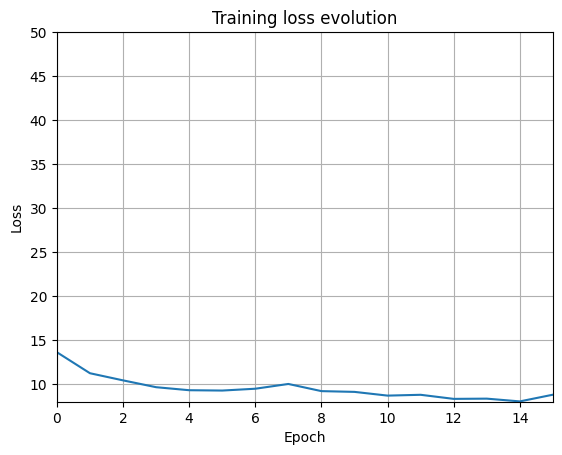

In [21]:
plt.plot(test_values['train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(8, 50)
plt.xlim(0, 15)
plt.show()

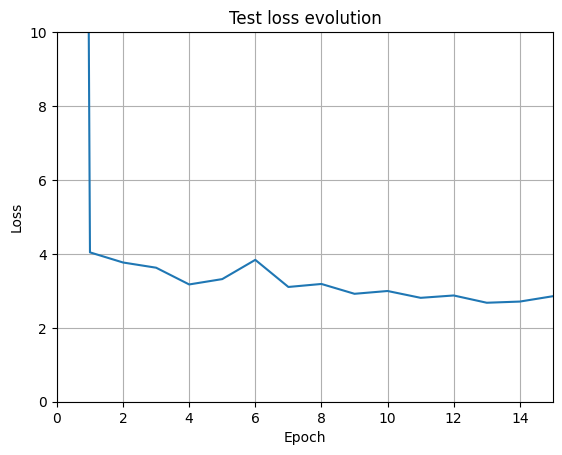

In [22]:
test_loss = np.array([168] + [i.cpu() for i in test_values['test_loss']])
plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(0, 10)
plt.xlim(0, 15)
plt.show()

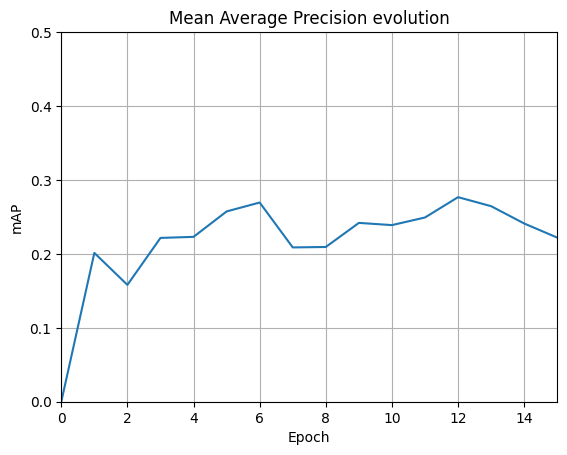

In [23]:
test_loss = np.array([0] + [i for i in test_values['mAP']])
plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Mean Average Precision evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(0, 0.5)
plt.xlim(0, 15)
plt.show()

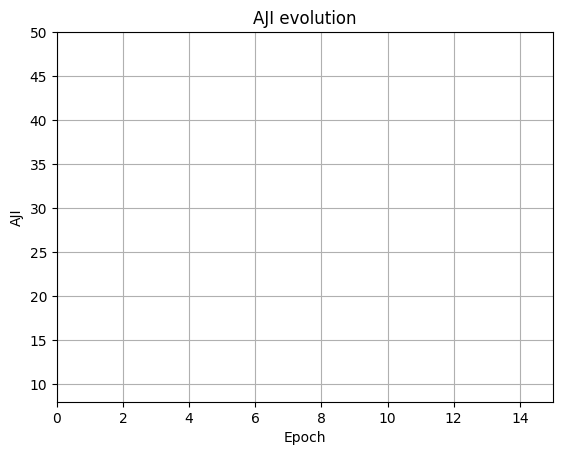

In [24]:
plt.plot(test_values['AJI'])
plt.xlabel('Epoch')
plt.ylabel('AJI')
plt.title('AJI evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(8, 50)
plt.xlim(0, 15)
plt.show()

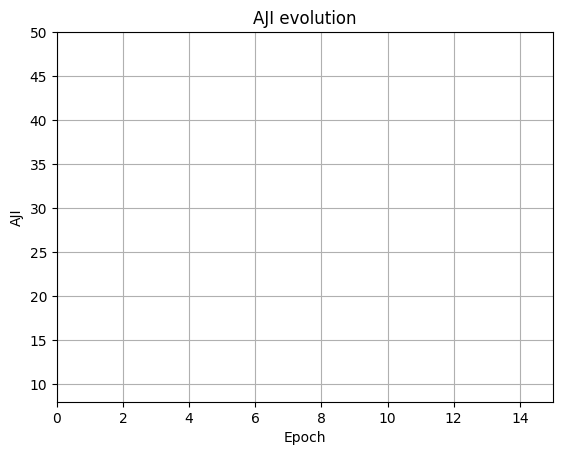

In [25]:
plt.plot(test_values['SBD'])
plt.xlabel('Epoch')
plt.ylabel('AJI')
plt.title('AJI evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(8, 50)
plt.xlim(0, 15)
plt.show()

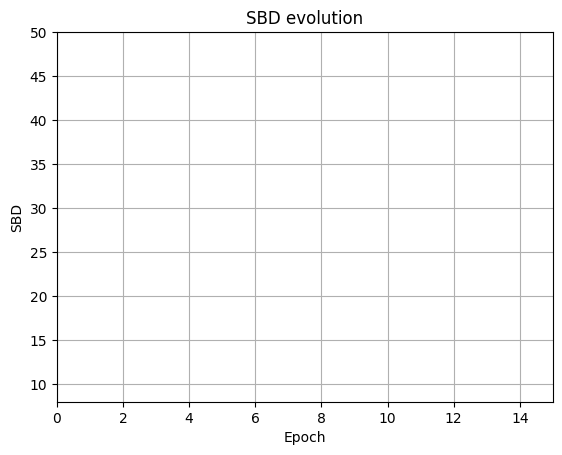

In [26]:
plt.plot(test_values['AJI'])
plt.xlabel('Epoch')
plt.ylabel('SBD')
plt.title('SBD evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(8, 50)
plt.xlim(0, 15)
plt.show()

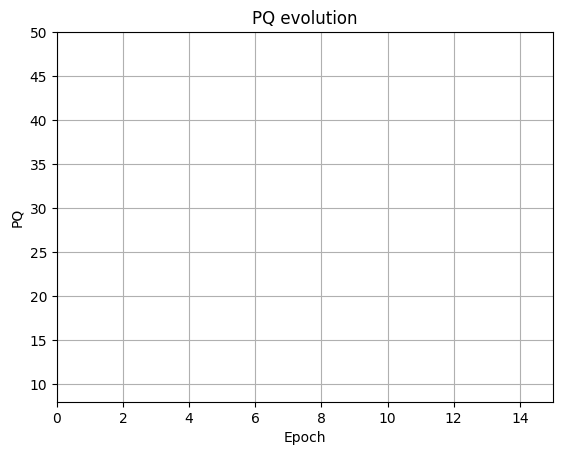

In [27]:
plt.plot(test_values['PQ'])
plt.xlabel('Epoch')
plt.ylabel('PQ')
plt.title('PQ evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(8, 50)
plt.xlim(0, 15)
plt.show()

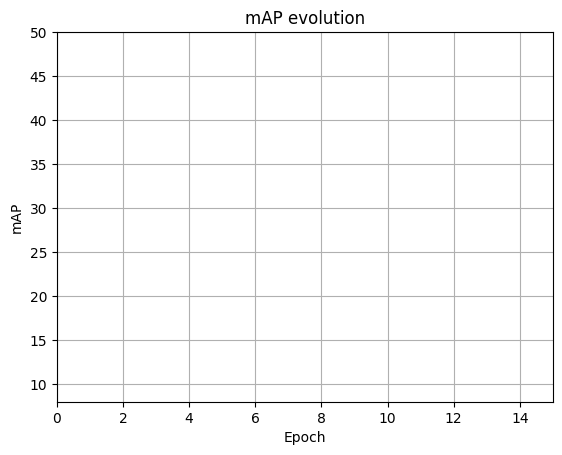

In [28]:
plt.plot(test_values['mAP'])
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(8, 50)
plt.xlim(0, 15)
plt.show()

ValueError: Input could not be cast to an at-least-1D NumPy array

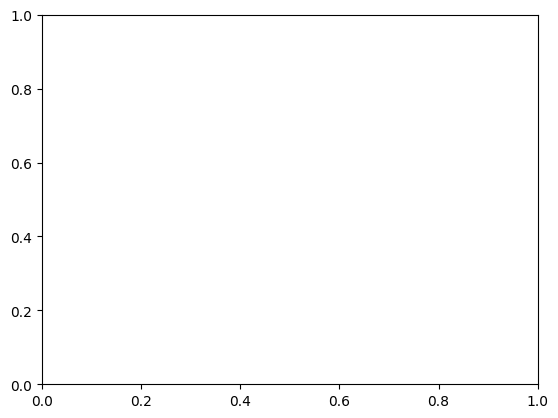

In [29]:
plt.plot(test_values['sAP'])
plt.xlabel('Epoch')
plt.ylabel('sAP')
plt.title('sAP evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(8, 50)
plt.xlim(0, 15)
plt.show()

In [25]:
# forward pass
outputs = None
with torch.no_grad():
  outputs = model(
          pixel_values=test_batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in test_batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in test_batch["class_labels"]],
  )
  results = processor.post_process_instance_segmentation(outputs)#, target_sizes=[img.size[::-1]])[0]
  print(outputs.loss)
  outputs = None

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.65 GiB of which 2.62 MiB is free. Process 12857 has 4.37 GiB memory in use. Including non-PyTorch memory, this process has 3.26 GiB memory in use. Of the allocated memory 3.06 GiB is allocated by PyTorch, and 87.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [44]:
e.add_example(anns_instances, anns_instances_gt)

e.AJI()
e.SBD()
e.PQ()
e.mAP()
e.sortedAP()

# leave segmentations
e.clear()

NameError: name 'anns_instances_gt' is not defined

In [46]:
evaluate(model,test_dataloader,e,device=device)

aggregatedJaccard: 0.5943538903099207, image average: False
SBD: 0.5640682401955659, image average: False
PQ: 0.43511435626021483, image average: False
mAP: 0.2008059370113231, image average: False
sortedAP: 0.365452444985023, image average: False


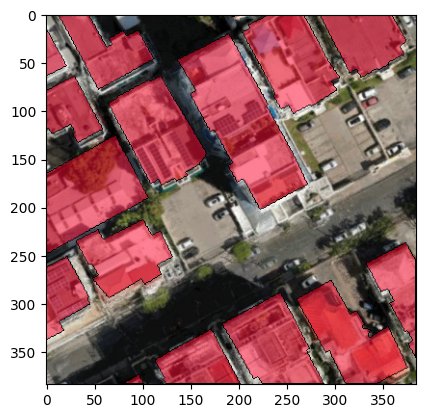

In [47]:
batch_index = 0

img = test_batch["pixel_values"][batch_index] 
img = unnormalize_image(img,processor=processor)
anns_semantic_gt = test_batch["class_labels"][batch_index].numpy()
anns_instances_gt = test_batch["mask_labels"][batch_index].numpy()
plot_data(img,anns_semantic=anns_semantic_gt,anns_instances=anns_instances_gt,background_class=255)

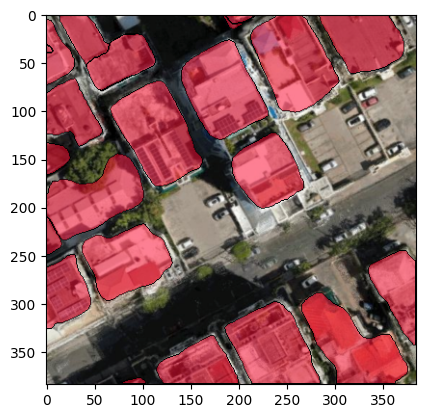

In [48]:
# you can pass them to processor for postprocessing
img = test_batch["pixel_values"][batch_index] 
img = unnormalize_image(img,processor=processor)

result = results[batch_index]
anns_instances = [get_mask(result['segmentation'], segment['id']) for segment in result['segments_info']]
anns_instances = np.stack(anns_instances,axis=0)
anns_semantic = np.array([segment['label_id'] for segment in result['segments_info']])
plot_data(img,anns_instances=anns_instances,anns_semantic=anns_semantic,background_class=255)

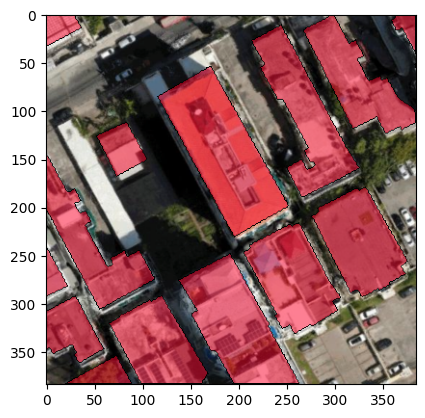

In [49]:
batch_index = 1

img = test_batch["pixel_values"][batch_index] 
img = unnormalize_image(img,processor=processor)
anns_semantic_gt = test_batch["class_labels"][batch_index].numpy()
anns_instances_gt = test_batch["mask_labels"][batch_index].numpy()
plot_data(img,anns_semantic=anns_semantic_gt,anns_instances=anns_instances_gt,background_class=255)

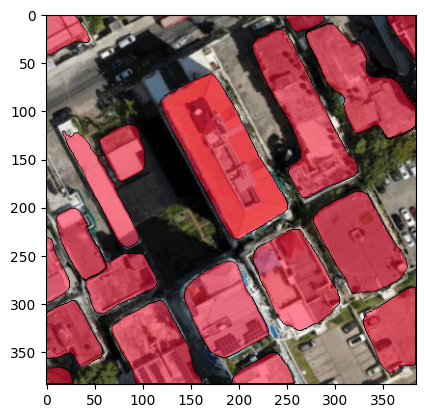

In [50]:
# you can pass them to processor for postprocessing
img = test_batch["pixel_values"][batch_index] 
img = unnormalize_image(img,processor=processor)

result = results[batch_index]
anns_instances = [get_mask(result['segmentation'], segment['id']) for segment in result['segments_info']]
anns_instances = np.stack(anns_instances,axis=0)
anns_semantic = np.array([segment['label_id'] for segment in result['segments_info']])
plot_data(img,anns_instances=anns_instances,anns_semantic=anns_semantic,background_class=255)

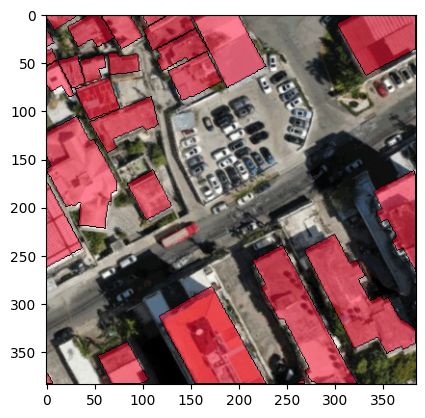

In [51]:
batch_index = 2

img = test_batch["pixel_values"][batch_index] 
img = unnormalize_image(img,processor=processor)
anns_semantic_gt = test_batch["class_labels"][batch_index].numpy()
anns_instances_gt = test_batch["mask_labels"][batch_index].numpy()
plot_data(img,anns_semantic=anns_semantic_gt,anns_instances=anns_instances_gt,background_class=255)

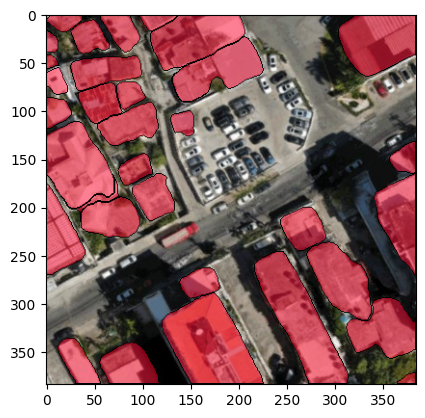

In [52]:
# you can pass them to processor for postprocessing
img = test_batch["pixel_values"][batch_index] 
img = unnormalize_image(img,processor=processor)

result = results[batch_index]
anns_instances = [get_mask(result['segmentation'], segment['id']) for segment in result['segments_info']]
anns_instances = np.stack(anns_instances,axis=0)
anns_semantic = np.array([segment['label_id'] for segment in result['segments_info']])
plot_data(img,anns_instances=anns_instances,anns_semantic=anns_semantic,background_class=255)

In [59]:
losses = [168,*losses]

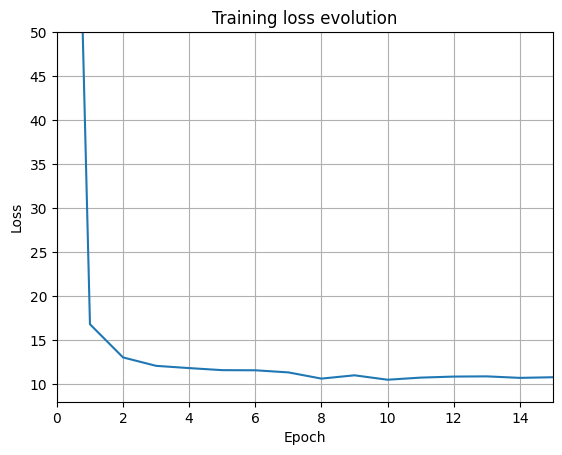

In [69]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss evolution')  # Optional, but nice to have
plt.grid(True)  # Optional, adds a grid for better readability
plt.ylim(8, 50)
plt.xlim(0, 15)
plt.show()